In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *


2024-10-17 09:28:37.291123: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-17 09:28:37.942782: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-10-17 09:28:37.942864: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-10-17 09:28:37.942873: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Show transition behavior with different SNR levels

In [2]:
from scipy.signal import resample
import jax.numpy as np
from encoding_information.models import PixelCNN, PoissonNoiseModel, AnalyticGaussianNoiseModel, FullGaussianProcess, StationaryGaussianProcess
from encoding_information import estimate_information
import time


N_objects = 5000
noise_sigma = 1e-3
num_samples_list = [1, 4, 9, 16, 25, 36]
upsampling_factor = 16
max_epochs = 5000
confidence = .95
num_nyquist_samples = 16
noise_sigmas_list = 1 / num_nyquist_samples / np.array([1e0, 1e1, 1e2, 1e3, 1e4])
test_set_fraction = 0.1
num_models_to_train = 5


upsampled_signal_length = upsampling_factor*num_nyquist_samples
objects_fn_delta = lambda : np.array([generate_random_object('delta', num_deltas=1, object_size=upsampled_signal_length) for i in range(N_objects)])
objects_fn_white_noise = lambda : np.array([generate_random_object('white_noise', object_size=upsampled_signal_length) for i in range(N_objects)])


mi_by_snr_median = {}
mi_by_snr_hi = {}
mi_by_snr_lo = {}
for noise_sigma in noise_sigmas_list:
  noise_sigma = float(noise_sigma)
  print('noise sigma', noise_sigma)
  mutual_information = []
  mi_hi = []
  mi_lo = []

  objects_fn = lambda : np.array([generate_random_object('delta', num_deltas=8, object_size=upsampled_signal_length) for i in range(N_objects)])


  # Find an optimal PSF for this object
  initial_kernel, initial_params, optimized_params, objects, _, _, _, _ = optimize_PSF_and_estimate_mi(
      objects_fn, noise_sigma, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampled_signal_length,
      max_epochs=max_epochs, )

  # compute the information with this psf when integrating over pixels of different sizes 
  for num_samples in tqdm(num_samples_list):


    # do the estimation
    scale_factor = 100000 # because these signals are 0-1 but pixel cnn is designed for photon counts
    test_objects = objects_fn()
    output_signals = conv_forward_model(optimized_params, test_objects,
                                                integrate_output_signals=False, num_nyquist_samples=num_nyquist_samples, upsampled_signal_length=upsampled_signal_length)
    
    # interpolate to higher resolution before integrating
    resampled_signal_length = num_samples * upsampling_factor

    resampled_output_signals = resample(output_signals, resampled_signal_length, axis=-1)
    # normalize to sum to 1
    resampled_output_signals = resampled_output_signals / np.sum(resampled_output_signals, axis=-1, keepdims=True)
    pixelated_signal = integrate_pixels(resampled_output_signals, num_samples)

    # amount of noise to add to the pixel depends on its area
    relative_sampling_area = num_nyquist_samples / num_samples
    pixel_variance = noise_sigma**2 * relative_sampling_area

    noisy_pixelated_signals = pixelated_signal + jax.random.normal(jax.random.PRNGKey(onp.random.randint(10000)), pixelated_signal.shape) * np.sqrt(pixel_variance)

    fake_images = noisy_pixelated_signals.reshape(-1, int(np.sqrt(num_samples)), int(np.sqrt(num_samples))) * scale_factor


    train_patches = fake_images[:int(fake_images.shape[0] * (1 - test_set_fraction))]
    test_patches = fake_images[int(fake_images.shape[0] * (1 - test_set_fraction)):]
    

    pixel_cnns = []
    stationary_gaussians = []
    full_gaussians = []
    for i in tqdm(range(num_models_to_train), desc='Training models'):
        pixelcnn = PixelCNN()
        pixelcnn.fit(train_patches, verbose=False)
        pixel_cnns.append(pixelcnn)
    
    noise_model = AnalyticGaussianNoiseModel(float(np.sqrt(pixel_variance) * scale_factor))

    estimate, lower, upper = estimate_information(pixel_cnns, noise_model, train_patches, test_patches, confidence_interval=confidence)

    mutual_information.append(estimate)
    mi_lo.append(lower)
    mi_hi.append(upper)
  mi_by_snr_median[noise_sigma] = mutual_information
  mi_by_snr_hi[noise_sigma] = mi_hi
  mi_by_snr_lo[noise_sigma] = mi_lo

noise sigma 0.0625


2024-10-17 09:29:48.357860: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 10.36


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


Epoch 1: validation NLL: 10.36


Epoch 2: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 181.77it/s]


Epoch 2: validation NLL: 10.36


Epoch 3: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 202.92it/s]


Epoch 3: validation NLL: 10.36


Epoch 4: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 210.66it/s]


Epoch 4: validation NLL: 10.36


Epoch 5: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 219.39it/s]


Epoch 5: validation NLL: 10.36


Epoch 6: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 361.11it/s]


Epoch 6: validation NLL: 10.36


Epoch 7: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 344.70it/s]


Epoch 7: validation NLL: 10.36


Epoch 8: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.83it/s]


Epoch 8: validation NLL: 10.36


Epoch 9: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 213.92it/s]


Epoch 9: validation NLL: 10.36


Epoch 10: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 369.12it/s]


Epoch 10: validation NLL: 10.36


Epoch 11: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 291.92it/s]


Epoch 11: validation NLL: 10.36


Epoch 12: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 118.32it/s]


Epoch 12: validation NLL: 10.36


Epoch 13: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 211.89it/s]


Epoch 13: validation NLL: 10.36


Epoch 14: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 176.49it/s]


Epoch 14: validation NLL: 10.36


Epoch 15: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 312.26it/s]


Epoch 15: validation NLL: 10.36


Epoch 16: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 345.78it/s]


Epoch 16: validation NLL: 10.36


Epoch 17: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 259.53it/s]


Epoch 17: validation NLL: 10.36


Epoch 18: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 352.55it/s]


Epoch 18: validation NLL: 10.36


Epoch 19: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 374.52it/s]


Epoch 19: validation NLL: 10.36


Epoch 20: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 274.41it/s]


Epoch 20: validation NLL: 10.36


Epoch 21: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 317.92it/s]


Epoch 21: validation NLL: 10.36


Epoch 22: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 230.54it/s]


Epoch 22: validation NLL: 10.36


Epoch 23: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 328.53it/s]


Epoch 23: validation NLL: 10.36


Epoch 24: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 172.04it/s]


Epoch 24: validation NLL: 10.36


Epoch 25: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 368.12it/s]


Epoch 25: validation NLL: 10.36


Epoch 26: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 293.02it/s]


Epoch 26: validation NLL: 10.36


Epoch 27: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 284.21it/s]


Epoch 27: validation NLL: 10.36


Epoch 28: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 314.39it/s]


Epoch 28: validation NLL: 10.36


Epoch 29: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 150.22it/s]


Epoch 29: validation NLL: 10.36


Epoch 30: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 175.73it/s]


Epoch 30: validation NLL: 10.36


Epoch 31: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 221.65it/s]


Epoch 31: validation NLL: 10.36


Epoch 32: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 207.10it/s]


Epoch 32: validation NLL: 10.36


Epoch 33: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 294.36it/s]


Epoch 33: validation NLL: 10.36


Epoch 34: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 332.49it/s]


Epoch 34: validation NLL: 10.36


precomputing masks and variances: 100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 26.44it/s]


evaluating likelihood


computing log likelihoods: 100%|█████████████████████████████████████████████████| 4/4 [00:00<00:00, 490.23it/s]
/2tb_nvme/your_username/GitRepos/EncodingInformation/src/encoding_information/models/conditional_entropy_models.py:41: UserWarning: The images argument is not used in the Analytic Gaussian noise model.
  warnings.warn("The images argument is not used in the Analytic Gaussian noise model.")
precomputing masks and variances: 100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 436.68it/s]


evaluating likelihood


Training models:   0%|                                                                    | 0/5 [00:00<?, ?it/s]

training:   0%|                                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▎                                                                | 1/200 [00:06<20:45,  6.26s/it]

training:   1%|▋                                                                | 2/200 [00:06<09:35,  2.90s/it]

training:   2%|▉                                                                | 3/200 [00:07<06:04,  1.85s/it]

training:   2%|█▎                                                               | 4/200 [00:07<04:23,  1.35s/it]

training:   2%|█▋                                                               | 5/200 [00:08<03:26,  1.06s/it]

training:   3%|█▉                                                               | 6/200 [00:09<03:05,  1.05it/s]

training:   4%|██▎                                                              | 7/200 

noise sigma 0.00625
Initial validation NLL: 9.56


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


Epoch 1: validation NLL: 9.56


Epoch 2: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 111.06it/s]


Epoch 2: validation NLL: 9.56


Epoch 3: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 168.60it/s]


Epoch 3: validation NLL: 9.56


Epoch 4: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 224.28it/s]


Epoch 4: validation NLL: 9.56


Epoch 5: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 265.80it/s]


Epoch 5: validation NLL: 9.56


Epoch 6: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 218.74it/s]


Epoch 6: validation NLL: 9.56


Epoch 7: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.32it/s]


Epoch 7: validation NLL: 9.56


Epoch 8: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 279.90it/s]


Epoch 8: validation NLL: 9.56


Epoch 9: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 217.73it/s]


Epoch 9: validation NLL: 9.56


Epoch 10: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 197.93it/s]


Epoch 10: validation NLL: 9.56


Epoch 11: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 201.50it/s]


Epoch 11: validation NLL: 9.56


Epoch 12: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 205.32it/s]


Epoch 12: validation NLL: 9.56


Epoch 13: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 169.18it/s]


Epoch 13: validation NLL: 9.56


Epoch 14: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 234.55it/s]


Epoch 14: validation NLL: 9.56


Epoch 15: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 365.61it/s]


Epoch 15: validation NLL: 9.56


Epoch 16: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 195.07it/s]


Epoch 16: validation NLL: 9.56


Epoch 17: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 179.94it/s]


Epoch 17: validation NLL: 9.56


Epoch 18: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 134.23it/s]


Epoch 18: validation NLL: 9.56


Epoch 19: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 349.29it/s]


Epoch 19: validation NLL: 9.56


Epoch 20: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 186.77it/s]


Epoch 20: validation NLL: 9.56


Epoch 21: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 143.46it/s]


Epoch 21: validation NLL: 9.56


Epoch 22: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 173.15it/s]


Epoch 22: validation NLL: 9.56


Epoch 23: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 314.53it/s]


Epoch 23: validation NLL: 9.56


Epoch 24: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 275.60it/s]


Epoch 24: validation NLL: 9.56


Epoch 25: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 150.41it/s]


Epoch 25: validation NLL: 9.56


Epoch 26: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 132.09it/s]


Epoch 26: validation NLL: 9.56


Epoch 27: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 156.96it/s]


Epoch 27: validation NLL: 9.56


Epoch 28: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 149.19it/s]


Epoch 28: validation NLL: 9.56


Epoch 29: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 158.88it/s]


Epoch 29: validation NLL: 9.56


Epoch 30: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 297.11it/s]


Epoch 30: validation NLL: 9.56


Epoch 31: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 225.60it/s]


Epoch 31: validation NLL: 9.56


Epoch 32: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 234.59it/s]


Epoch 32: validation NLL: 9.56


Epoch 33: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 254.63it/s]


Epoch 33: validation NLL: 9.56


precomputing masks and variances: 100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 484.97it/s]

evaluating likelihood



precomputing masks and variances: 100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 391.94it/s]


evaluating likelihood


Training models:   0%|                                                                    | 0/5 [00:00<?, ?it/s]

training:   0%|                                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▎                                                                | 1/200 [00:04<14:48,  4.47s/it]

training:   1%|▋                                                                | 2/200 [00:05<07:40,  2.32s/it]

training:   2%|▉                                                                | 3/200 [00:06<05:13,  1.59s/it]

training:   2%|█▎                                                               | 4/200 [00:06<04:00,  1.23s/it]

training:   2%|█▋                                                               | 5/200 [00:07<03:19,  1.02s/it]

training:   3%|█▉                                                               | 6/200 [00:08<02:56,  1.10it/s]

training:   4%|██▎                                                              | 7/200 

noise sigma 0.000625
Initial validation NLL: 9.51


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


Epoch 1: validation NLL: 9.51


Epoch 2: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 141.07it/s]


Epoch 2: validation NLL: 9.51


Epoch 3: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 339.26it/s]


Epoch 3: validation NLL: 9.51


Epoch 4: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 285.95it/s]


Epoch 4: validation NLL: 9.51


Epoch 5: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 365.90it/s]


Epoch 5: validation NLL: 9.51


Epoch 6: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 168.07it/s]


Epoch 6: validation NLL: 9.51


Epoch 7: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 187.87it/s]


Epoch 7: validation NLL: 9.51


Epoch 8: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 174.94it/s]


Epoch 8: validation NLL: 9.51


Epoch 9: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 240.71it/s]


Epoch 9: validation NLL: 9.51


Epoch 10: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 304.16it/s]


Epoch 10: validation NLL: 9.51


Epoch 11: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 163.85it/s]


Epoch 11: validation NLL: 9.51


Epoch 12: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 166.96it/s]


Epoch 12: validation NLL: 9.51


Epoch 13: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 222.42it/s]


Epoch 13: validation NLL: 9.51


Epoch 14: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 278.91it/s]


Epoch 14: validation NLL: 9.51


Epoch 15: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 274.28it/s]


Epoch 15: validation NLL: 9.51


Epoch 16: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 162.97it/s]


Epoch 16: validation NLL: 9.51


Epoch 17: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 202.72it/s]


Epoch 17: validation NLL: 9.51


Epoch 18: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 176.59it/s]


Epoch 18: validation NLL: 9.51


Epoch 19: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 275.45it/s]


Epoch 19: validation NLL: 9.51


Epoch 20: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 331.02it/s]


Epoch 20: validation NLL: 9.51


Epoch 21: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 316.03it/s]


Epoch 21: validation NLL: 9.51


Epoch 22: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 315.15it/s]


Epoch 22: validation NLL: 9.51


Epoch 23: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.63it/s]


Epoch 23: validation NLL: 9.51


Epoch 24: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 336.30it/s]


Epoch 24: validation NLL: 9.51


Epoch 25: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 172.20it/s]


Epoch 25: validation NLL: 9.51


Epoch 26: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 147.50it/s]


Epoch 26: validation NLL: 9.51


Epoch 27: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 266.66it/s]


Epoch 27: validation NLL: 9.51


Epoch 28: 100%|██████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 243.50it/s]


Epoch 28: validation NLL: 9.51


precomputing masks and variances: 100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 498.09it/s]

evaluating likelihood



precomputing masks and variances: 100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 424.95it/s]


evaluating likelihood


Training models:   0%|                                                                    | 0/5 [00:00<?, ?it/s]

training:   0%|                                                                         | 0/200 [00:00<?, ?it/s]

training:   0%|▎                                                                | 1/200 [00:04<14:22,  4.34s/it]

training:   1%|▋                                                                | 2/200 [00:04<07:00,  2.12s/it]

training:   2%|▉                                                                | 3/200 [00:05<04:42,  1.43s/it]

training:   2%|█▎                                                               | 4/200 [00:06<03:35,  1.10s/it]

training:   2%|█▋                                                               | 5/200 [00:06<03:02,  1.07it/s]

training:   3%|█▉                                                               | 6/200 [00:07<02:38,  1.23it/s]

training:   4%|██▎                                                              | 7/200 

noise sigma 6.25e-05
Initial validation NLL: 767.07


Epoch 1: 100%|████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]


Epoch 1: validation NLL: 10.75


Epoch 2: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 123.14it/s]


Epoch 2: validation NLL: 10.06


Epoch 3: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 155.24it/s]


Epoch 3: validation NLL: 9.83


Epoch 4: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 149.09it/s]


Epoch 4: validation NLL: 9.72


Epoch 5: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 171.88it/s]


Epoch 5: validation NLL: 9.66


Epoch 6: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 345.47it/s]


Epoch 6: validation NLL: 9.62


Epoch 7: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 324.81it/s]


Epoch 7: validation NLL: 9.59


Epoch 8: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 323.91it/s]


Epoch 8: validation NLL: 9.57


Epoch 9: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 182.79it/s]


Epoch 9: validation NLL: 9.55


Epoch 10: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 293.27it/s]


Epoch 10: validation NLL: 9.54


Epoch 11: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 200.18it/s]


Epoch 11: validation NLL: 9.53


Epoch 12: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 231.13it/s]


Epoch 12: validation NLL: 9.52


Epoch 13: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 287.71it/s]


Epoch 13: validation NLL: 9.51


Epoch 14: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 197.43it/s]


Epoch 14: validation NLL: 9.51


Epoch 15: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 157.36it/s]


Epoch 15: validation NLL: 9.50


Epoch 16: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 369.93it/s]


Epoch 16: validation NLL: 9.50


Epoch 17: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 343.94it/s]


Epoch 17: validation NLL: 9.50


Epoch 18: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 226.17it/s]


Epoch 18: validation NLL: 9.49


Epoch 19: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 196.42it/s]


Epoch 19: validation NLL: 9.49


Epoch 20: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 202.55it/s]


Epoch 20: validation NLL: 9.49


Epoch 21: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 374.32it/s]


Epoch 21: validation NLL: 9.49


Epoch 22: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 353.12it/s]


Epoch 22: validation NLL: 9.49


Epoch 23: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 151.51it/s]


Epoch 23: validation NLL: 9.48


Epoch 24: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 195.83it/s]


Epoch 24: validation NLL: 9.48


Epoch 25: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 195.34it/s]


Epoch 25: validation NLL: 9.48


Epoch 26: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 297.43it/s]


Epoch 26: validation NLL: 9.48


Epoch 27: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 159.78it/s]


Epoch 27: validation NLL: 9.48


Epoch 28: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 187.40it/s]


Epoch 28: validation NLL: 9.48


Epoch 29: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 209.91it/s]


Epoch 29: validation NLL: 9.48


Epoch 30: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 346.58it/s]


Epoch 30: validation NLL: 9.48


Epoch 31: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 183.05it/s]


Epoch 31: validation NLL: 9.48


Epoch 32: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 346.18it/s]


Epoch 32: validation NLL: 9.48


Epoch 33: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 305.13it/s]


Epoch 33: validation NLL: 9.47


Epoch 34: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 179.88it/s]


Epoch 34: validation NLL: 9.47


Epoch 35: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 282.56it/s]


Epoch 35: validation NLL: 9.47


Epoch 36: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 189.88it/s]


Epoch 36: validation NLL: 9.47


Epoch 37: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 165.42it/s]


Epoch 37: validation NLL: 9.47


Epoch 38: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 165.51it/s]


Epoch 38: validation NLL: 9.47


Epoch 39: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 276.76it/s]


Epoch 39: validation NLL: 9.47


Epoch 40: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 248.35it/s]


Epoch 40: validation NLL: 9.47


Epoch 41: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 356.51it/s]


Epoch 41: validation NLL: 9.47


Epoch 42: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 167.78it/s]


Epoch 42: validation NLL: 9.47


Epoch 43: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 167.28it/s]


Epoch 43: validation NLL: 9.47


Epoch 44: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 270.71it/s]


Epoch 44: validation NLL: 9.47


Epoch 45: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 183.57it/s]


Epoch 45: validation NLL: 9.47


Epoch 46: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 171.06it/s]


Epoch 46: validation NLL: 9.47


Epoch 47: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 246.14it/s]


Epoch 47: validation NLL: 9.47


Epoch 48: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 231.38it/s]


Epoch 48: validation NLL: 9.47


Epoch 49: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 160.12it/s]


Epoch 49: validation NLL: 9.47


Epoch 50: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 196.09it/s]


Epoch 50: validation NLL: 9.47


Epoch 51: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 323.11it/s]


Epoch 51: validation NLL: 9.47


Epoch 52: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 162.54it/s]


Epoch 52: validation NLL: 9.47


Epoch 53: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 199.61it/s]


Epoch 53: validation NLL: 9.47


Epoch 54: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 339.26it/s]


Epoch 54: validation NLL: 9.47


Epoch 55: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 151.67it/s]


Epoch 55: validation NLL: 9.47


Epoch 56: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 204.51it/s]


Epoch 56: validation NLL: 9.47


Epoch 57: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 257.64it/s]


Epoch 57: validation NLL: 9.47


Epoch 58: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 202.71it/s]


Epoch 58: validation NLL: 9.47


Epoch 59: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 168.62it/s]


Epoch 59: validation NLL: 9.47


Epoch 60: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 334.21it/s]


Epoch 60: validation NLL: 9.47


precomputing masks and variances: 100%|██████████████| 4/4 [00:00<00:00, 354.59it/s]

evaluating likelihood



precomputing masks and variances: 100%|██████████████| 4/4 [00:00<00:00, 397.58it/s]


evaluating likelihood


computing log likelihoods: 100%|█████████████████████| 4/4 [00:00<00:00, 375.01it/s]
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 239.14it
Training models:   0%|                                        | 0/5 [00:00<?, ?it/s]

training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:04<14:51,  4.48s/it]

training:   1%|▎                                    | 2/200 [00:05<07:21,  2.23s/it]

training:   2%|▌                                    | 3/200 [00:05<04:49,  1.47s/it]

training:   2%|▋                                    | 4/200 [00:06<03:36,  1.11s/it]

training:   2%|▉                                    | 5/200 [00:06<02:57,  1.10it/s]

training:   3%|█                                    | 6/200 [00:07<02:32,  1.27it/s]

training:   4%|█▎                                   | 7/200 [00:07<02:17,  1.40it/s]

training:   4%|█▍                                   | 8/

noise sigma 6.25e-06


/2tb_nvme/your_username/GitRepos/EncodingInformation/src/encoding_information/models/gaussian_process.py:55: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.001
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +
/2tb_nvme/your_username/GitRepos/EncodingInformation/src/encoding_information/models/gaussian_process.py:55: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.01
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
Initial validation NLL: 42.48


Epoch 1: 100%|████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Epoch 1: validation NLL: 9.44


Epoch 2: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 255.07it/s]


Epoch 2: validation NLL: 9.37


Epoch 3: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 156.08it/s]


Epoch 3: validation NLL: 9.35


Epoch 4: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 267.56it/s]


Epoch 4: validation NLL: 9.35


Epoch 5: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 308.54it/s]


Epoch 5: validation NLL: 9.34


Epoch 6: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 205.63it/s]


Epoch 6: validation NLL: 9.34


Epoch 7: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 278.69it/s]


Epoch 7: validation NLL: 9.34


Epoch 8: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 291.86it/s]


Epoch 8: validation NLL: 9.34


Epoch 9: 100%|███████████████████████████████████████| 1/1 [00:00<00:00, 327.99it/s]


Epoch 9: validation NLL: 9.34


Epoch 10: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 363.68it/s]


Epoch 10: validation NLL: 9.34


Epoch 11: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 226.16it/s]


Epoch 11: validation NLL: 9.34


Epoch 12: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 267.89it/s]


Epoch 12: validation NLL: 9.34


Epoch 13: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 310.69it/s]


Epoch 13: validation NLL: 9.34


Epoch 14: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 236.18it/s]


Epoch 14: validation NLL: 9.34


Epoch 15: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 291.21it/s]


Epoch 15: validation NLL: 9.34


Epoch 16: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 309.61it/s]


Epoch 16: validation NLL: 9.34


Epoch 17: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 192.47it/s]


Epoch 17: validation NLL: 9.34


Epoch 18: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 359.93it/s]


Epoch 18: validation NLL: 9.34


Epoch 19: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 156.87it/s]


Epoch 19: validation NLL: 9.34


Epoch 20: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 265.46it/s]


Epoch 20: validation NLL: 9.34


Epoch 21: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 229.15it/s]


Epoch 21: validation NLL: 9.34


Epoch 22: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 357.30it/s]


Epoch 22: validation NLL: 9.34


Epoch 23: 100%|██████████████████████████████████████| 1/1 [00:00<00:00, 356.75it/s]


Epoch 23: validation NLL: 9.34


precomputing masks and variances: 100%|██████████████| 4/4 [00:00<00:00, 409.78it/s]

evaluating likelihood



precomputing masks and variances: 100%|██████████████| 4/4 [00:00<00:00, 386.98it/s]


evaluating likelihood


computing log likelihoods: 100%|█████████████████████| 4/4 [00:00<00:00, 375.46it/s]
Bootstrapping to compute confidence interval: 100%|█| 100/100 [00:00<00:00, 219.67it
Training models:   0%|                                        | 0/5 [00:00<?, ?it/s]

training:   0%|                                             | 0/200 [00:00<?, ?it/s]

training:   0%|▏                                    | 1/200 [00:04<15:16,  4.61s/it]

training:   1%|▎                                    | 2/200 [00:05<07:37,  2.31s/it]

training:   2%|▌                                    | 3/200 [00:06<05:17,  1.61s/it]

training:   2%|▋                                    | 4/200 [00:06<04:09,  1.27s/it]

training:   2%|▉                                    | 5/200 [00:07<03:32,  1.09s/it]

training:   3%|█                                    | 6/200 [00:08<03:08,  1.03it/s]

training:   4%|█▎                                   | 7/200 [00:09<02:52,  1.12it/s]

training:   4%|█▍                                   | 8/

/tmp/ipykernel_5140/1087950307.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_colormap = plt.cm.get_cmap('inferno')


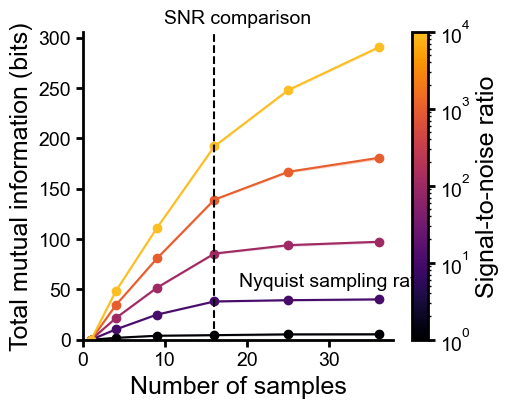

In [3]:
snrs = (1 / num_nyquist_samples) / np.array(noise_sigmas_list)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))

# Define the start and end points--used so that high values aren't too light against white background
start, end = 0, 0.85
base_colormap = plt.cm.get_cmap('inferno')

from matplotlib.colors import LinearSegmentedColormap
# Create a new colormap from the portion of the original colormap
colormap = LinearSegmentedColormap.from_list(
    'trunc({n},{a:.2f},{b:.2f})'.format(n=base_colormap.name, a=start, b=end),
    base_colormap(np.linspace(start, end, 256))
)

colors = colormap(np.linspace(0, 1, len(noise_sigmas_list)))

for i, ((noise_sigma, mutual_information), snr) in enumerate(zip(mi_by_snr_median.items(), snrs)):

    total_mi = np.array(mutual_information) * np.array(num_samples_list)
    mi_lo = np.array(mi_by_snr_lo[noise_sigma]) * np.array(num_samples_list)
    mi_hi = np.array(mi_by_snr_hi[noise_sigma]) * np.array(num_samples_list)

    ax.plot(num_samples_list, total_mi,  'o-', color=colors[i], label=snr)
    ax.fill_between(num_samples_list, mi_lo, mi_hi, color=colors[i], alpha=0.2)
    
    ax.set_xlabel('Number of samples')
    ax.set_ylabel('Total mutual information (bits)')

    # ax.set(ylim=(0, max(1.1 * np.max(total_mi), ax.get_ylim()[1])))

# plot a dashed line at the number of nyquist samples
ax.axvline(num_nyquist_samples, linestyle='--', color='k')
ax.text(num_nyquist_samples + 3, 0.2 * np.max(total_mi), 'Nyquist sampling rate', rotation=0, va='center')
clear_spines(ax)
# ax.legend()
ax.set(title='SNR comparison', ylim=(0, None), xlim=(0, None))


from matplotlib.colors import LogNorm
# Create a scalar mappable object with the colormap and the snrs range
norm = LogNorm(vmin=np.min(snrs), vmax=np.max(snrs))
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])

# Add the colorbar to the figure
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Signal-to-noise ratio')
fig.savefig('/home/your_username/figures/1d_signals/' + 'sampling_density_snr' + '.pdf', transparent=True, dpi=600)